# EDA of international Football Matches

## Section 1: Business Understanding


In this notebook we will take a closer look into the evolution of international football matches (i.e. matches played between countries) through the years.

#### Questions to be explored:
- How the international football scenario change over the years?    
    - More games? 
    - Percentage of each continent in the total of games
    - Teams from different continents play with each other more or less today than they did in the past?
    - Did more different teams win games today than in the past? (não existe mais bobo no futebol)


- How is the performance of a winning world cup team in the years the preceed the tournament?
    - How many games?
    - How many wins, losses, draws?
    - How is the performance in the year before the WC?
    - If its a team from America, how many games they played agaist european teams?

    
- How is Brazil comming to this World Cup comparing to the recent World Cups?
    - How many wins, losses, draws?
    - What percentage of the points possible it gets?
    - Which continents Brazil played against?

## Section 2: Data Understanding

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

### Gather Data

The data consists of insternational football matches that happened since 1872.

Every row is a match with the following columns:
- **date**: Date of the match
- **home_team**: Name of the home team
- **away_team**: Name of the away team
- **home_score**: Home team goals
- **away_score**: Away team goals
- **tournament**: Tournament name
- **city**: City where the match took place
- **country**: Country where the match took place.
- **neutral**: Whether the match took place at a neutral venue or not.

In [3]:
# Start the analysis by reading the results file from the "data" folder
df_results = pd.read_csv("data/results.csv")

# Convert the date column to datetime to became easly to perform operations after
df_results['date']  = pd.to_datetime(df_results['date'])

print(f"There are {len(df_results)} matches")
print(f"The first game was {df_results['date'].min().date()} and the last was {df_results['date'].max().date()}")

There are 43752 matches
The first game was 1872-11-30 and the last was 2022-06-14


In [5]:
# Check the datatypes
df_results.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
city                  object
country               object
neutral                 bool
dtype: object

In [4]:
# Pre visualize the data
df_results.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


## Section 3: Data Preparation

### Data Cleaning and Feature Creation

In this section we will create some features that we will use during the analisys.

In the cell bellow we create the features that we can extract right away from the data, without the nedd of any external data.

In [7]:
def get_game_outcome ( home_score, away_score):
    """
    The outcome will be encoded as:
        - D: Draw
        - H: Home team wins
        - A: Away team wins
    """
    if (home_score == away_score):
        return 'D' # Draw
    elif (home_score > away_score):
        return 'H' # Home team wins
    elif (home_score < away_score):
        return 'A' # Away team wins

def winning_team(home_team, away_team, outcome):
    """
    This function returns the name of the winning team
    after checking the outcome
    """
    if (outcome == 'H'):
        return home_team
    elif (outcome == 'A'):
        return away_team
    else:
        return '-'

def losing_team(home_team, away_team, outcome):
    """
    This function returns the name of the loosing team
    after checking the outcome
    """
    if (outcome == 'A'):
        return home_team
    elif (outcome == 'H'):
        return away_team
    else:
        return '-'

# The outcome of the game
df_results['outcome'] = df_results.apply(lambda x: get_game_outcome(x.home_score, x.away_score), axis=1)

# Name of the winning team
df_results['winning_team'] =  df_results.apply(lambda x: winning_team(x.home_team, x.away_team, x.outcome), axis=1)

# Name of the losing team
df_results['losing_team'] =  df_results.apply(lambda x: losing_team(x.home_team, x.away_team, x.outcome), axis=1)

# Score difference
df_results['score_difference'] = df_results.apply(lambda x: abs(x.home_score - x.away_score), axis=1)

# Teams envolved on the match
df_results['teams_envolved'] = df_results.apply(lambda x: [x.home_team, x.away_team], axis = 1)

# Year of the game
df_results['year'] = df_results['date'].apply(lambda x: x.year)

# Month of the game
df_results['month'] = df_results['date'].apply(lambda x: x.month_name())

# Day of the game
df_results['day'] = df_results['date'].apply(lambda x: x.day)

# Day of the week of the game
df_results['day_name'] = df_results['date'].apply(lambda x: x.day_name())

# The home team actually play at home?
df_results['home_playing_home'] = df_results.apply(lambda x: 'y' if x.home_team == x.country else 'n', axis = 1)

# Extract only the date from the datetime object
df_results['date'] = df_results['date'].apply(lambda x: x.date())

Now we are going to create some features using an external data source, that is data mapping each country name with it's corresponding continent.

This might be usefull because then we will be able to have a clear picture of where football is stronger in the world and compare games that happened in different parts of the globe.

In [8]:
# Read the csv
df_geo_regions = pd.read_csv('data/geographic-regions.csv')
# Fill the nan values
df_geo_regions.fillna('-', inplace = True)
# Rename columns
df_geo_regions.rename(columns = {'Country or Area':'country_reff', 'Region Name':'continent'}, inplace = True)

# There are some missing countries that were written in a different way on the data.
# Here we create this dictionary to add this missing values
missing_countries_dict = {
                            'England':'Europe',
                            'Scotland':'Europe',
                            'Wales':'Europe',
                            'Turkey':'Europe',
                            'Tanzania':'Africa',
                            'China PR':'Asia',
                            'Republic of Ireland':'Europe',
                            'Iran':'Asia',
                            'Northern Ireland':'Europe',
                            'Russia':'Europe',
                            'Ivory Coast':'Africa',
                            'Yugoslavia':'Europe',
                            'Hong Kong':'Asia',
                            'Bolivia':'Americas',
                            'Czechoslovakia':'Europe',
                            'Venezuela':'Americas',
                            'Soviet Union':'Europe',
                            'Czech Republic':'Europe',
                            'Vietnam':'Asia',
                            'German DR':'Europe',
                            'Syria':'Asia',
                            'Malaya':'Asia',
                            'Moldova':'Europe',
                            'DR Congo':'Africa',
                            'Cape Verde':'Africa',
                            'Netherlands Antilles':'Americas',
                            'Vietnam Republic':'Asia',
                            'Zaïre':'Africa',
                            'Taiwan':'Asia',
                            'Laos':'Asia'
}

def get_continent ( label, df_results ):
    """
    This function maps the countries in the original data source with the continents
    gathered from the geographic-regions.csv file.

    Input:
        label: The name of the column with country names
        df_results: Dataframe you want to add the columns

    Output
        Series with the names of the corresponding continents
    """
    df_merged = df_results.merge(df_geo_regions[['country_reff','continent']], how = 'left', left_on =label, right_on = 'country_reff')
    df_merged['continent'] = df_merged['continent'].fillna('-')
    return df_merged.apply(lambda x: missing_countries_dict.get(x[label], "not found") if x.continent == '-' else x.continent, axis=1 )

# Get the continent of the game, the away_team and the home_team
df_results['game_continent'] = get_continent ( 'country', df_results )
df_results['home_team_continent'] = get_continent ( 'home_team', df_results )
df_results['away_team_continent'] = get_continent ( 'away_team', df_results )

# The home team is playing in their continent?
df_results['home_playing_continent'] = df_results.apply(lambda x: 'y' if x.home_team_continent == x.game_continent else 'n', axis = 1)

# The away team is playing in their continent?
df_results['away_playing_continent'] = df_results.apply(lambda x: 'y' if x.away_team_continent == x.game_continent else 'n', axis = 1)

# Both of the teams are from the same continent?
df_results['same_continent'] = df_results.apply(lambda x: 'y' if x.away_team_continent == x.home_team_continent else 'n', axis = 1)

# Continents envolved on the match
df_results['continents_envolved'] = df_results.apply(lambda x: [x.home_team_continent, x.away_team_continent], axis = 1)

## Section 4 Evaluation

In this section we will start to answer the questions that we propose in the Business Understanding section.

The code will be organized as follows: 
1. At the begining we will have the _bigger question_ that indicates what major topic we are exploring, followed by the smaller questions to be analyzed
2. Each question will be presented with a brief explanation of it's motivations
3. Then there will be a code cell where we manipulate the data and make the visualization for the question
4. After that you will find some comments about what the plot showed and some conclusions

### How the international football scenario change over the years? 

#### How the number of games and teams evolved over the years?

We will start our analisys by answer the first question that might come to our minds, see if our intuition that the number of games and teams is indeed increasing.
Here, for the sake of a better visualization, I consider only data from 1930 forward (when the first WC happen and football became officially more “international”).

Our data manipulation here will consists basically in grouping all the matches by year and getting a list with unique countries that played in that year.

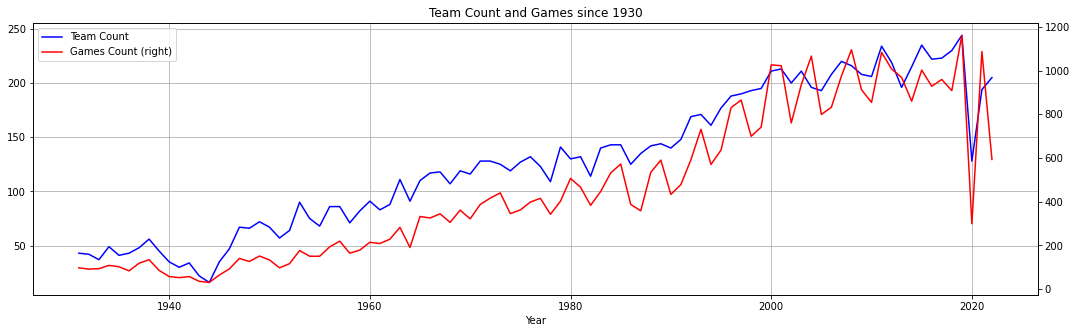

In [9]:
# Filtering the data
df_filtered = df_results[df_results['year'] > 1930]


list_team_count = [] # List that will contain the team count for every year
for y in df_filtered['year'].unique():
    matches_list = df_filtered.groupby(by = 'year').get_group(y)['teams_envolved'].to_list() # Grouping by year and getting the countries that played
    countries = [m[0] for m in matches_list] # Gets the home team
    countries.extend([m[1] for m in matches_list]) # Gets the away team
    list_team_count.append(len(set(countries)))

# Series with the amount of games played in each year and the corresponding year as index
series_team_count = pd.Series(index=df_filtered['year'].unique(), data=list_team_count)
# List with how many games append in each year
series_game_count = df_filtered['year'].value_counts(sort = False)


# ************************************ PLOTS *********************************************
plt.figure(figsize=(18,5))
plt.xlabel('Year')
plt.title("Team Count and Games since 1930")

ax1 = series_team_count.plot(color='blue', grid=True, label='Team Count')
ax2 = series_game_count.plot(color='red', grid=True, secondary_y=True, label='Games Count')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

The graph above shows what we already expected, the number of games and countries playing is increasing, almost at a constant rate, especially after the end of World War II.

#### What percentage of teams each continent had over the years

The idea here is to see how “international” football really are? To do that we will check the percentage of countries from each continent in the matches.

To get this result we will group the data by year and count how many matches were played by countries from each continent. This value will be later normalized to get the percentages.

One important thing to mentioned here is that, to get a smoother plot, we will be using the rolling mean of the last for years. And because we are calcualting the rolling mean we will filter the data for years before, starting in 1926, so the first non-null value will be 1930

<AxesSubplot:title={'center':'Percentage of games for continent'}>

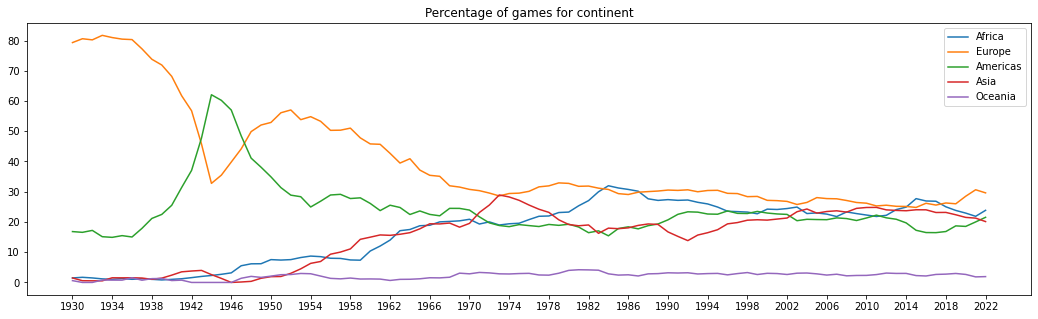

In [11]:
# Filtering the data
df_filtered = df_results[df_results['year'] > 1926]


list_continent_count = [] # List that will contain the team count for every continent
for y in df_filtered['year'].unique():
    matches_list = df_filtered.groupby(by = 'year').get_group(y)['continents_envolved'].to_list()
    continents = [m[0] for m in matches_list] # Gets the home team continent
    continents.extend([m[1] for m in matches_list]) # Gets the away team continent
    # Count of many of each continent we have
    africa = len([a for a in continents if a == 'Africa'])
    europe = len([a for a in continents if a == 'Europe'])
    americas = len([a for a in continents if a == 'Americas'])
    asia = len([a for a in continents if a == 'Asia'])
    oceania = len([a for a in continents if a == 'Oceania'])
    not_found = len([a for a in continents if a == 'not found'])

    # Its a list of lists, where every element will become a row in the dataframe 
    list_continent_count.append([africa, europe, americas, asia, oceania, not_found])

# Creating the final dataframe
df_contient_count = pd.DataFrame(index=df_filtered['year'].unique(), 
                                data=list_continent_count, 
                                columns = ['Africa', 'Europe', 'Americas', 'Asia', 'Oceania', 'not found'])

# Sum to get the total for each year
df_contient_count['total'] = df_contient_count.sum(axis=1)

# Calculate the roling mean of 4 years to have a smoother plot
# Here we use the dropna to remove the first null values of the rolling mean
df_contient_count = df_contient_count.rolling(4).mean().dropna()

# Calculate the percentage for each year
for c in [c for c in df_contient_count.columns if c != 'total']:
    df_contient_count[c] = df_contient_count.apply(lambda x: round(100*(x[c]/x['total']),2), axis = 1)

# ************************************ PLOTS *********************************************
xticks_values = np.arange(1930, 2026, 4).tolist()
df_contient_count[['Africa', 'Europe', 'Americas', 'Asia', 'Oceania']].plot(figsize=(18,5),
                                                                            title = "Percentage of games for continent",
                                                                            xticks = xticks_values)

We can see that Europe and the Americas (North, Central and South) played most of the matches in the first half of the 20th century. But Africa and Asia stared to catch up, specially in the 70's.

Nowadays it’s really nice to see that, except by Oceania, all the other continents had around 20% of the games played. An equality that is hard to see in others aspects of human interactions.

#### Teams from diffent continent play with each other more or less they did in the past

As football becomes more international is natural that teams from every part of the world face each other more often, here we will take a look on that.

Here we will take advantage of the _same_continent_ feature created before, this will facilitate our filter in the analisys.

Again here using the roling mean.


<AxesSubplot:title={'center':'Percentage of matches with different continents teams'}>

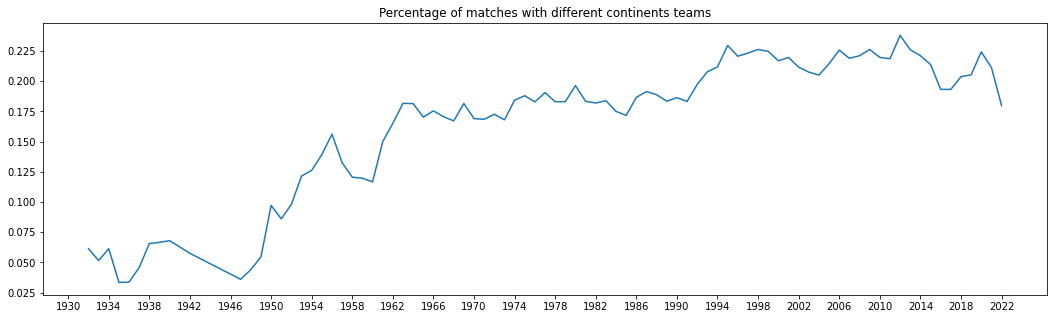

In [12]:
# Count how many different teams played international matches in each year
df_filtered_continent = df_results[(df_results['year'] > 1926) & (df_results['same_continent'] == 'n')]
df_filtered = df_results[df_results['year'] > 1926]

series_diff_continents_count = df_filtered_continent['year'].value_counts(sort = False)
series_game_count = df_filtered['year'].value_counts(sort = False)

# Plot the rolling mean to get a smoother value
xticks_values = np.arange(1930, 2026, 4).tolist()
(series_diff_continents_count/series_game_count).dropna().rolling(4).mean().dropna().plot(figsize=(18,5),
                                                                                          title = "Percentage of matches with different continents teams",
                                                                                          xticks = xticks_values)

It’s possible to see by the graph that the number of matches was increasing until the 60's where it reached its first plateau. In the 90's we saw an increase again, but since 2010 it is apparently drooping.

#### European and American teams now play less with each other

In recent years we saw more investment in continent-level competitions, specially with the creation of the UEFA Nations League in 2019, that end up decreasing the friendly matches, where it was usually when countries from different countries face each other. So lets check if the games where europeans face americans start to decrease

Here we will calculate the percentage of the matches where americans face europeans compared to the total matches they were involved. To plot we will filter after 1950 because the that before that was really influenced by World War II

<AxesSubplot:title={'center':'Percentage of matches Europeans vs Americans'}>

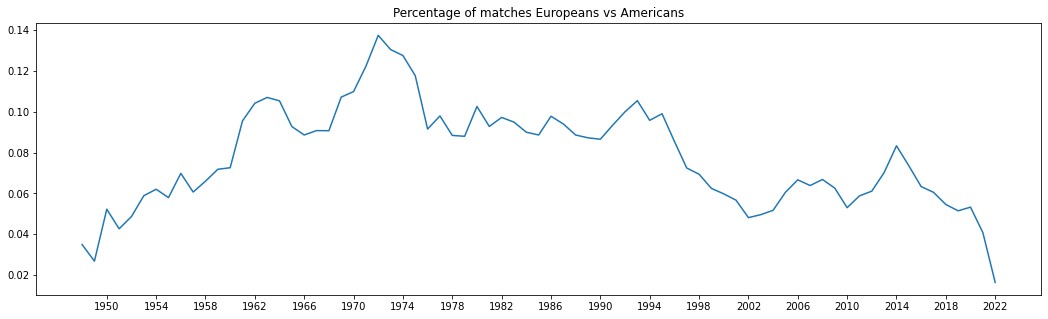

In [42]:
# Total of games that had at least one european or one american
df_america_or_europe = df_results[(df_results['year'] > 1930) & ((df_results['home_team_continent'] == 'Americas') | 
                                                                (df_results['home_team_continent'] == 'Europe') | 
                                                                (df_results['away_team_continent'] == 'Americas') |
                                                                (df_results['away_team_continent'] == 'Europe'))]

# Total of games that Amreicans and Europeans play each other
df_america_vs_europe = df_results[(df_results['year'] > 1930) & (((df_results['home_team_continent'] == 'Americas') & 
                                                                (df_results['away_team_continent'] == 'Europe')) | 
                                                                ((df_results['home_team_continent'] == 'Europe') & 
                                                                (df_results['away_team_continent'] == 'Americas')))]


america_or_europe_count = df_america_or_europe['year'].value_counts(sort = False)
america_vs_europe_count = df_america_vs_europe['year'].value_counts(sort = False)

# Plot the rolling mean to get a smoother value
xticks_values = np.arange(1950, 2026, 4).tolist()
(america_vs_europe_count/america_or_europe_count).dropna().rolling(4).mean().dropna().plot(figsize=(18,5),
                                                                                          title = "Percentage of matches Europeans vs Americans",
                                                                                          xticks = xticks_values)

Its possible to see that the level of matches were already decreasing after 1994 and reach the lowest level since 1950 after the UEFA Nationals League creation in 2019

# Did more different teams win games today than in the past?

Let's check how many different teams are winning at least one matche in each year. The idea here is to see if more teams are winning and thus becoming more competitive


The idea here is here similiar to the previous ones. Only this time we will get the names of the winning teams, and then create a set to get the unique teams. This value will be normalized to get the percentage

<AxesSubplot:title={'center':'Percentage of teams that win games'}, xlabel='year'>

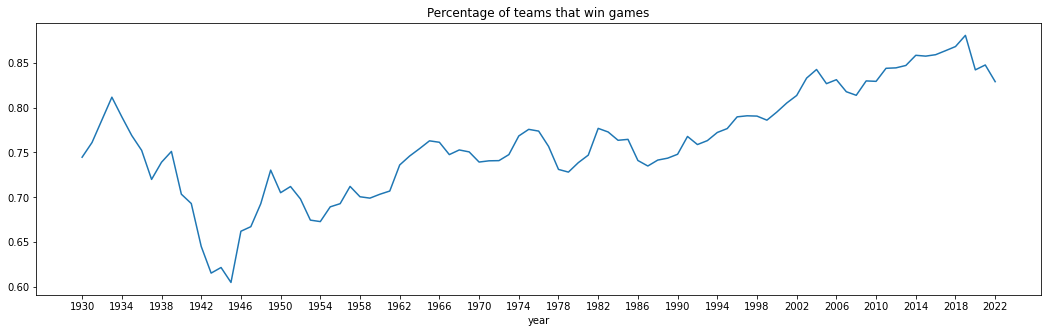

In [17]:
# Filtering data
df_filtered = df_results[df_results['year'] > 1926]

df_list_count = []
for y in df_filtered['year'].unique():
    df_year = df_filtered.groupby(by = 'year').get_group(y)
    matches_list = df_year['teams_envolved'].to_list()
    countries = [m[0] for m in matches_list] # Gets the home team
    countries.extend([m[1] for m in matches_list]) # Gets the away team
    total_countries = len(set(countries))
    winning_teams_list = []
    for i,row in df_year.iterrows():
        if (row['outcome'] == 'H'): # Home teams wins
            winning_teams_list.append(row['home_team'])
        elif(row['outcome'] == 'A'): # Away team wins
            winning_teams_list.append(row['away_team'])
    total_winners = len(set(winning_teams_list)) # Gets unique countries that win at least one game
    df_list_count.append([y,total_countries,total_winners])

df_winners = pd.DataFrame(df_list_count, columns = ['year', 'total_countries', 'total_winners'])

df_winners['ratio'] = df_winners['total_winners'] / df_winners['total_countries'] 

xticks_values = np.arange(1930, 2026, 4).tolist()
df_winners.set_index('year').rolling(4).mean().dropna()['ratio'].plot(figsize=(18,5),
                                                                        title = "Percentage of teams that win games",
                                                                        xticks = xticks_values)


It’s very clear that there is an increasing trend. Before the 2020 Covid-19 pandemic, almost 90% of the countries had won a game in that year. 20 years before that value was bellow 80% of the teams.

### How is the performance of a winning world cup team in the years the preceed the tournament?


To start this section I will first define what I meant by “the years that preceded the tournament”.

The WC happens every four years, and people usually call that period the “WC cycle”.

So, what I will do is, for every world cup winner, I will look for the games that happened into the four years before. For example, Brazil won the 2002 WC, so I will look into every game that happened after the 1998 WC final and the 2002 WC start match.

I decided to start with the 1934 WC because that was the first “official 4 years cycle”, since the first WC happened in 1930 and after it finish the countries at least imagined (and prepared) for another WC in four years.

To facilitate this analysis we will use another external data source, which contains more detailed information about the World Cups. We will use this date basically to get the winner of each year and the start/end date of every WC

In [13]:
# First reading the data and already droping rows that are entirely nulls
df_wc_games = pd.read_csv("data/WorldCupMatches.csv").dropna()
df_wc_winners = pd.read_csv("data/WorldCups.csv").dropna()

# THe year came originally as a flot because of the nan values, so i convert here to int
df_wc_games['Year'] = df_wc_games['Year'].apply(int)
# Convert the date to datetime
df_wc_games['Datetime'] = pd.to_datetime(df_wc_games['Datetime']).apply(lambda x: x.date())
# The data makes a difference between west and east germany in the 20th century, here i just replace by only "germany"
df_wc_winners['Winner'] = df_wc_winners['Winner'].apply(lambda x: 'Germany' if x.__contains__('Germany') else x)

# Get the first and last day of the world cup
wc_start_end_list = []
for y in df_wc_games['Year'].unique():
    df_year = df_wc_games.groupby(by = 'Year').get_group(y)
    winner = df_wc_winners.groupby(by = 'Year').get_group(y)['Winner'].to_list()[0]
    wc_start_end_list.append([y, df_year['Datetime'].min(), df_year['Datetime'].max(), winner])

# The data only goes until 2014, so we manually add the Data from 2018
wc_start_end_list.append([2018, datetime(2018,6,14).date(), datetime(2018,7,15).date(), 'France'])

# Final dataframe with the start/end date and the winner of every WC
df_wc_start_end = pd.DataFrame(wc_start_end_list, columns = ['year', 'date_start', 'date_end','winner'])



# Get a dictionary that has the Country names as Keys and the Continent as Values
total_unique_countries = pd.concat([df_results['home_team'], df_results['away_team']]).unique()
dict_country_continent = {}
for c in total_unique_countries:
    try: 
        dict_country_continent[c] = df_results[df_results['home_team'] == c]['home_team_continent'].unique()[0]
    except:
        # If the team never had a game playing home
        dict_country_continent[c] = df_results[df_results['away_team'] == c]['away_team_continent'].unique()[0]

# Adding the continents
df_wc_start_end['continent'] = df_wc_start_end['winner'].apply(lambda x: dict_country_continent[x])

In [14]:
# Visualize the data
df_wc_start_end.head(5)

,year,date_start,date_end,winner,continent
0,1930,1930-07-13,1930-07-30,Uruguay,Americas
1,1934,1934-05-27,1934-06-10,Italy,Europe
2,1938,1938-06-04,1938-06-19,Italy,Europe
3,1950,1950-06-24,1950-07-16,Uruguay,Americas
4,1954,1954-06-16,1954-07-04,Germany,Europe


#### How many games, wins, losses, draws?

To obtain all of this metrtrics we will perform the same data manipulation. The goal here is to obtain a dataframe that count, for each WC cycle, how many games, wins, draws ans losses the future WC winner had

In [15]:
wc_history_list = []
for i in range(1,len(df_wc_start_end)):
    start_cycle_year = df_wc_start_end['year'][i-1] # year that start the next wc cycle
    end_cycle_year = df_wc_start_end['year'][i] # wc year, that ends the wc cycle
    future_wc_winner = df_wc_start_end['winner'][i] # team that end up winning the WC

    # Here we filter the DF to get only the games involving the winning team and that happened after the end of the past WC and before the begining of the future WC
    df_wc_cycle = df_results[(df_results['teams_envolved'].apply(lambda x: x.__contains__(future_wc_winner))) &
                        (df_results['date'] > df_wc_start_end[df_wc_start_end['year'] == start_cycle_year]['date_end'].max()) & # greater than the end of last WC
                        (df_results['date'] < df_wc_start_end[df_wc_start_end['year'] == end_cycle_year]['date_start'].min())]  # smaller than the begging of current wc

    total_games_played = len(df_wc_cycle)
    w = 0
    l = 0
    d = 0
    for t in df_wc_cycle['winning_team']:
        if (t == future_wc_winner): # How many wins the team had
            w+=1
        elif (t == '-'): # How many draws the team had
            d += 1
        else:
            l += 1 # How many losses the team had

    wc_history_list.append([end_cycle_year, future_wc_winner, total_games_played, w, d, l])

# Final DF
df_wc_history = pd.DataFrame(wc_history_list, columns = ['wc_year', 'winner', 'games_played', 'wins', 'draws', 'losses'])

In [16]:
def show_values(axs, orient="v", space=.01):
    """
    Function extracted from: https://www.statology.org/seaborn-barplot-show-values/

    This function is used to plot the values above in the columns of a matplotlib plot
    """
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

Here we plot the total games played by the team in that period

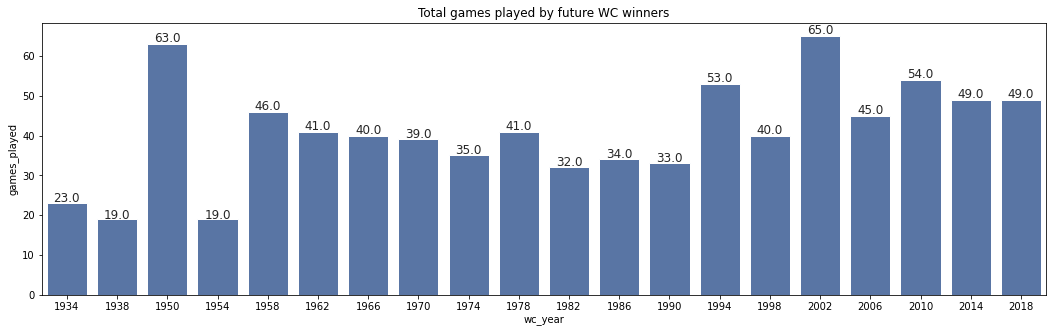

In [9]:
plt.figure(figsize=(18,5))
plt.title("Total games played by future WC winners")
sns.set_theme(style="whitegrid")
p = sns.barplot(data = df_wc_history, x= 'wc_year', y='games_played', color = 'b')

#show values on barplot
show_values(p)

Here we can see that there is not a clear increasing (or decreasing) trend of games played. The level apparently jumped after 1990, but there is no strong pattern.

Now we take a look at the percentage of wins, losses and draws

The data manipulation here is just to calulate the percentage of each kind of result

<AxesSubplot:title={'center':'Percentage of wins, draws, losses'}, xlabel='wc_year'>

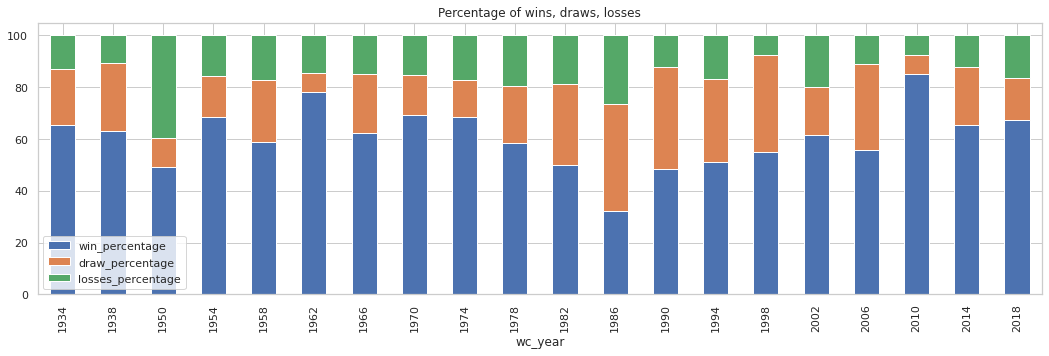

In [10]:
df_wc_history['win_percentage'] = (df_wc_history['wins'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))
df_wc_history['draw_percentage'] = (df_wc_history['draws'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))
df_wc_history['losses_percentage'] = (df_wc_history['losses'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))

df_wc_history.drop(columns = ['winner', 'games_played', 'wins', 'draws', 'losses']).set_index('wc_year').plot(kind = 'bar',
                                                                                                                 stacked=True,
                                                                                                                 figsize=(18,5),
                                                                                                                 title = "Percentage of wins, draws, losses")

From the image above we can see that the future WC winners usually doesn’t have an extraordinary performance, only Spain won more then 80% of their games in the 2010 WC cycle. Since the 70’s the rule seems to be to win around 60% of the games.

#### How is the performance in the year before the WC

Now we will do a similiar analisys, but this time considering only the year before the WC

<AxesSubplot:title={'center':'Percentage of wins, draws, losses'}, xlabel='wc_year'>

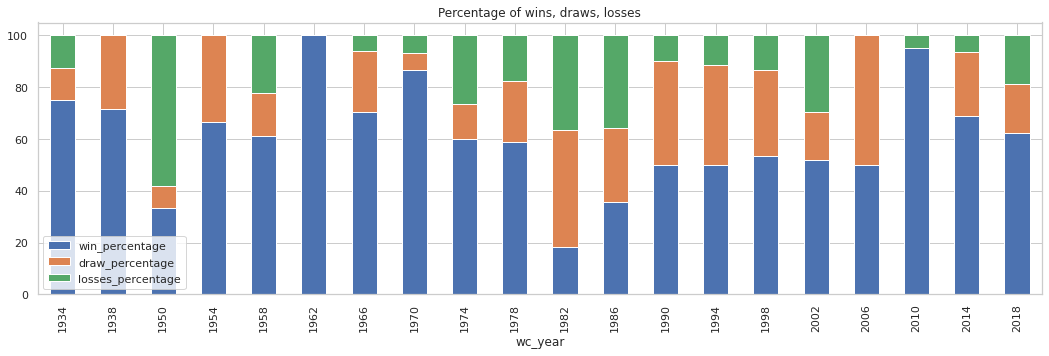

In [11]:
wc_history_list = []
for i in range(1,len(df_wc_start_end)):
    start_cycle_year = df_wc_start_end['year'][i-1] # year that start the next wc cycle
    end_cycle_year = df_wc_start_end['year'][i] # wc year, that ends the wc cycle
    future_wc_winner = df_wc_start_end['winner'][i] # team that end up winning the WC

    df_wc_cycle = df_results[(df_results['teams_envolved'].apply(lambda x: x.__contains__(future_wc_winner))) &
                        (df_results['date'] > datetime(end_cycle_year - 1,1,1).date()) & # greater than the beginign of the year that preceds the WC
                        (df_results['date'] < df_wc_start_end[df_wc_start_end['year'] == end_cycle_year]['date_start'].min())]  # smaller than the begging of current wc

    total_games_played = len(df_wc_cycle)
    w = 0
    l = 0
    d = 0
    for t in df_wc_cycle['winning_team']:
        if (t == future_wc_winner): # How many wins the team had
            w+=1
        elif (t == '-'): # How many draws the team had
            d += 1
        else:
            l += 1 # How many losses the team had

    wc_history_list.append([end_cycle_year, future_wc_winner, total_games_played, w, d, l])
    # print(df_wc_start_end['year'][i-1],df_wc_start_end['year'][i], df_wc_start_end['winner'][i])

df_wc_history = pd.DataFrame(wc_history_list, columns = ['wc_year', 'winner', 'games_played', 'wins', 'draws', 'losses'])

df_wc_history['win_percentage'] = (df_wc_history['wins'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))
df_wc_history['draw_percentage'] = (df_wc_history['draws'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))
df_wc_history['losses_percentage'] = (df_wc_history['losses'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))

df_wc_history.drop(columns = ['winner', 'games_played', 'wins', 'draws', 'losses']).set_index('wc_year').plot(kind = 'bar',
                                                                                                                 stacked=True,
                                                                                                                 figsize=(18,5),
                                                                                                                 title = "Percentage of wins, draws, losses")

Here we see much more flutuation, with games results becoming more inconsisting for every year. There’s a saying that arriving at a world cup as the favorite team for the title doesn’t bring much luck, and that seems to hold, at least looking from that perspective.

#### When Brazil and Argentina won WC, did they play more with europeans in their preparation?

The idea here is to see if playing more against europeans prepare you more to the WC

The data manipulation here is again similar to the other cases, only this time we will filter Brazil and Argentina's games and calculate how many games were played against europeans.

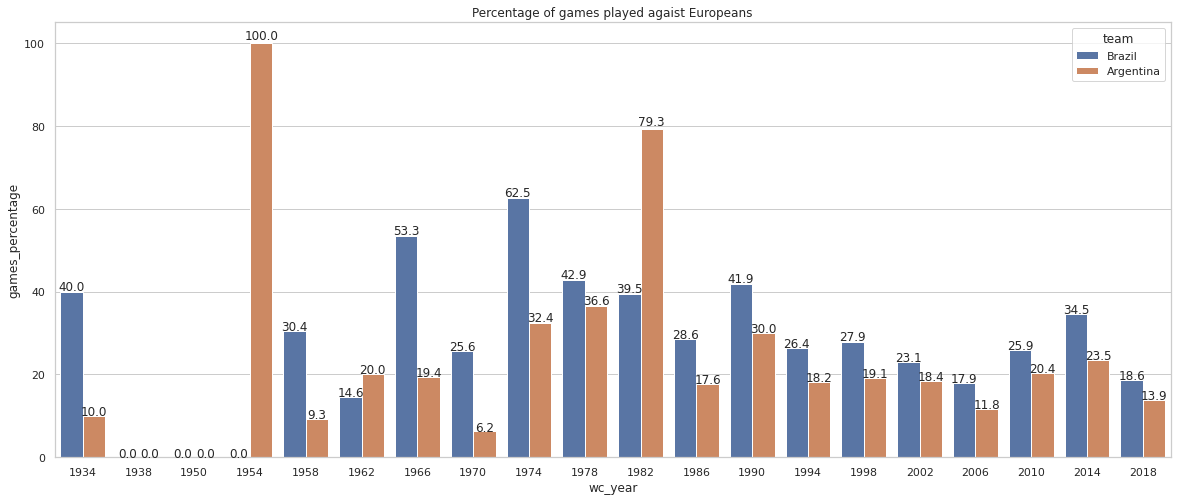

In [15]:
wc_history_list = []
for i in range(1,len(df_wc_start_end)):
    start_cycle_year = df_wc_start_end['year'][i-1] # year that start the next wc cycle
    end_cycle_year = df_wc_start_end['year'][i] # wc year, that ends the wc cycle
    for t in ['Brazil','Argentina']:
        # Filtering to get Brazil and Argentina game history for each WC cycle
        df_wc_cycle = df_results[(df_results['teams_envolved'].apply(lambda x: x.__contains__(t))) &
                            (df_results['date'] > df_wc_start_end[df_wc_start_end['year'] == start_cycle_year]['date_end'].max()) & # greater than the end of last WC
                            (df_results['date'] < df_wc_start_end[df_wc_start_end['year'] == end_cycle_year]['date_start'].min())]  # smaller than the begging of current wc
        total_games_played = len(df_wc_cycle)
        # Filter to get only the games played against europeans
        games_against_europeans = len(df_wc_cycle[df_wc_cycle['continents_envolved'].apply(lambda x: True if 'Europe' in x else False)])
        wc_history_list.append([end_cycle_year, t, total_games_played, games_against_europeans])

df_br_ar_history = pd.DataFrame(wc_history_list, columns=['wc_year', 'team', 'total_games_played', 'games_against_europeans'])
# creating the column that will have the percentages
df_br_ar_history['games_percentage'] = (df_br_ar_history['games_against_europeans'] / df_br_ar_history['total_games_played']).apply(lambda x: round(100*x,2))

# ******************************* PLOT **********************************
plt.figure(figsize=(20,8))
plt.title("Percentage of games played agaist Europeans")
sns.set_theme(style="whitegrid")
p = sns.barplot(data = df_br_ar_history, x = 'wc_year', y = 'games_percentage', hue = 'team' )
#show values on barplot
show_values(p)

From the graph we can see that Brazil and Argentina indeed play more against Europeans sometimes. But in those times, did they reach the WC finals?


In the visualization bellow I intend to look exactly that. We will separate the years that they reach to the finals, for that years we will compute the average % of games played against europeans in the WC. This values will be compared with the year they did not reach the finals.

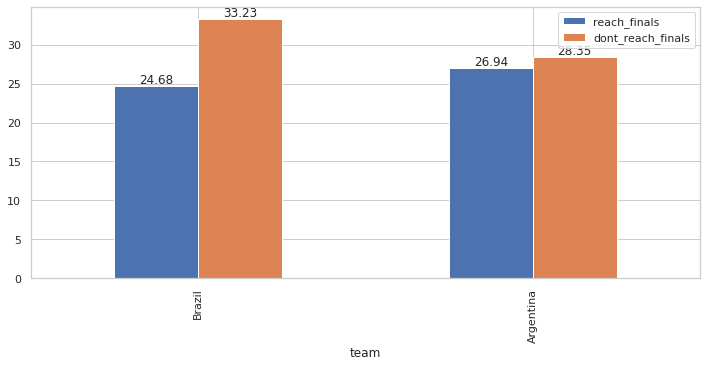

In [16]:
df_filtered = df_br_ar_history[df_br_ar_history['wc_year'] > 1950]

br_year_finals = [1950,1958,1962,1970,1994,1998,2002] # Years that brazil reach the WC final
ar_years_finals = [1978,1986,1990,2014] # Years that aregentina reach the WC final

dict_final_wc_years = {
    'Brazil':br_year_finals,
    'Argentina':ar_years_finals
}

df_list = []
for t in ['Brazil', 'Argentina']:
    # Percentage of games when the team reach the finals
    win_p = round(df_filtered[(df_filtered['team'] == t) & df_filtered['wc_year'].apply(lambda x: True if x in dict_final_wc_years[t] else False)]['games_percentage'].mean(),2)
    # Percentage of games when the team dont reach the finals
    loss_p = round(df_filtered[(df_filtered['team'] == t) & df_filtered['wc_year'].apply(lambda x: False if x in dict_final_wc_years[t] else True)]['games_percentage'].mean(),2)
    df_list.append([t,win_p,loss_p])

# Final dataframe
df_percenatge = pd.DataFrame(df_list, columns = ['team','reach_finals','dont_reach_finals'])


# *********************** PLOT *****************************************
ax = df_percenatge.plot(kind = 'bar', x = 'team',figsize=(12,5))

for container in ax.containers:
    ax.bar_label(container)

Just to make more understandable, the graph shows that, on average, when Brazil, for example, don’t reach the finals, they played 33.23% of their games against Europeans in the WC cycle. When Brazil reach the finals, that value drops to 24.68% of the matches.

From Argentina we can see they are very close to each other, with a percentage difference of less then 2%. But for Brazil the difference is almost 10%, a much higher difference.

### How Brazil is comming to the 2022 WC

In this part of the analisys I will look just to Brazil's data to see how they are going to the WC. If you want to see another country, you can just change the _team_ variable in the code cell bellow.

#### How many wins, losses, draws?

Here we are doing basically the same thing we did on the previous section, only this time we will calculate the metrics only for Brazil, and we will add data from 2018 forward, to see their performance in the 2022 WC cycle.

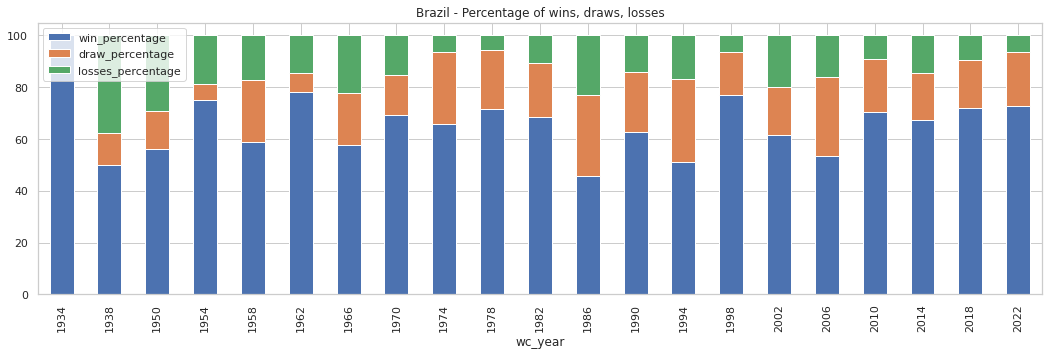

In [16]:
# That that you will be looking at
team = 'Brazil'

# Adding 2022 WC dates to get the data of the games after 2018
df_2022 = pd.DataFrame([[2022,datetime(2022,11,21).date(),datetime(2022,12,18).date(),'-','-']], columns = df_wc_start_end.columns, index = [21])
df_wc_start_end_2022 = pd.concat([df_wc_start_end,df_2022])

wc_history_list = []
for i in range(1,len(df_wc_start_end_2022)):
    start_cycle_year = df_wc_start_end_2022['year'][i-1] # year that start the next wc cycle
    end_cycle_year = df_wc_start_end_2022['year'][i] # wc year, that ends the wc cycle

    df_wc_cycle = df_results[(df_results['teams_envolved'].apply(lambda x: x.__contains__(team))) &
                        (df_results['date'] > df_wc_start_end_2022[df_wc_start_end_2022['year'] == start_cycle_year]['date_end'].max()) & # greater than the end of last WC
                        (df_results['date'] < df_wc_start_end_2022[df_wc_start_end_2022['year'] == end_cycle_year]['date_start'].min())]  # smaller than the begging of current wc

    total_games_played = len(df_wc_cycle)
    w = 0
    l = 0
    d = 0
    for t in df_wc_cycle['winning_team']:
        if (t == team): # How many wins the team had
            w+=1
        elif (t == '-'): # How many draws the team had
            d += 1
        else:
            l += 1 # How many losses the team had

    wc_history_list.append([end_cycle_year, team, total_games_played, w, d, l])

# Final Dataframe
df_wc_history = pd.DataFrame(wc_history_list, columns = ['wc_year', 'team', 'games_played', 'wins', 'draws', 'losses'])

# Calculating the percentages
df_wc_history['win_percentage'] = (df_wc_history['wins'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))
df_wc_history['draw_percentage'] = (df_wc_history['draws'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))
df_wc_history['losses_percentage'] = (df_wc_history['losses'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))

# ************************************** PLOT **************************************
df_wc_history.drop(columns = ['team', 'games_played', 'wins', 'draws', 'losses']).set_index('wc_year').plot(kind = 'bar',
                                                                                                                 stacked=True,
                                                                                                                 figsize=(18,5),
                                                                                                                 title = f"{team} - Percentage of wins, draws, losses")

We can see that Brazil seems to have a performance very close to what it has had since 2010. We will compare it better in the following question.

#### What percentage of the points possible it gets?

To make things more comparable, I will convert the Wins, Draws and Losses into points. Following the same convention the nationals club tournaments follow, that is, 3 points for a win, 1 for a draw and 0 for a loss. After that I calculate the percentage of possible points Brazil got in every WC cycle, the graph below shows these values.

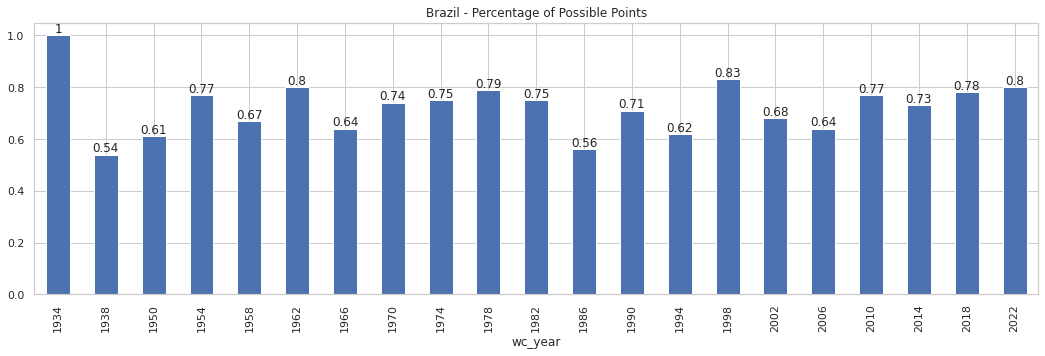

In [17]:
df_wc_history['possible_points'] = df_wc_history['games_played']*3 # possible points (winning all games)
df_wc_history['obtained_points'] = df_wc_history['wins']*3 + df_wc_history['draws'] # points obtained
df_wc_history['points_ratio'] = (df_wc_history['obtained_points'] / df_wc_history['possible_points']).apply(lambda x: round(x,2)) # percentage of points

# ***************************** PLOT *********************************
ax = df_wc_history.set_index('wc_year')['points_ratio'].plot(kind = 'bar' ,figsize=(18,5), title = f'{team} - Percentage of Possible Points')

for container in ax.containers:
    ax.bar_label(container)

plt.savefig('brazil_points.png')

We can see that so far, at the middle of 2022, when I’m writing this text, Brazil has 80% of possible points, close to what they had in 2018 and only bellow 1998, when they reached the finals and lost to France.

#### Which tournaments they played in the WC preparation?

Now lest take a look into the tournaments that Brazil played in the WC cylces from 1994 foreward. I choose this year because the competitions change a lot over the years, so considering far in the past will produce many different competitions tha do not exist today.

The data manipulation part is very similiar to previous cases, but this time, instead of calculating the number of games, wins etc we will count the kind of tournaments.

We will also filter tournaments with less than 4 games to reduce the noise

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

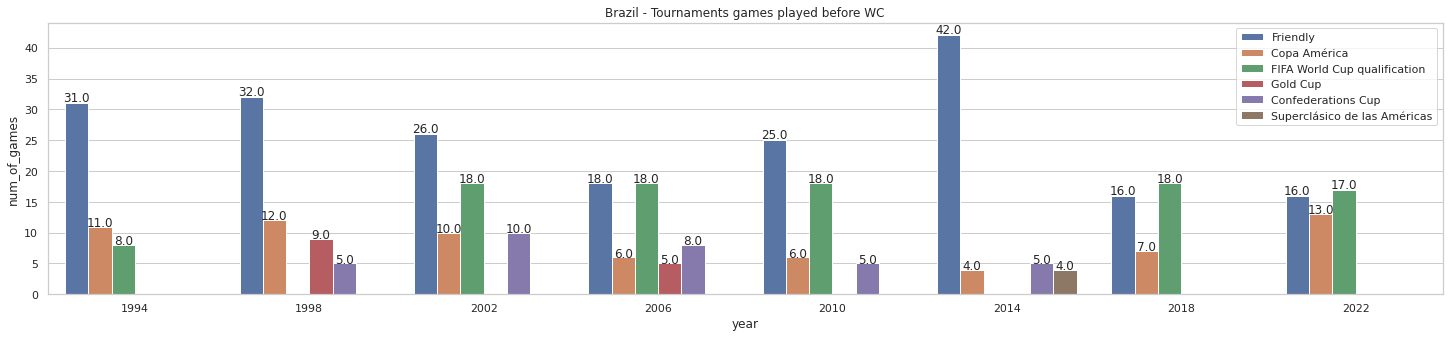

In [80]:
wc_history_list = []
# dtaframe that we will concat the data
df_tournaments = pd.DataFrame()
for i in range(14,len(df_wc_start_end_2022)): # Starting at the 1994 WC
    start_cycle_year = df_wc_start_end_2022['year'][i-1] # year that start the next wc cycle
    end_cycle_year = df_wc_start_end_2022['year'][i] # wc year, that ends the wc cycle

    # same filters we did in the previous ones
    df_wc_cycle = df_results[(df_results['teams_envolved'].apply(lambda x: x.__contains__(team))) &
                        (df_results['date'] > df_wc_start_end_2022[df_wc_start_end_2022['year'] == start_cycle_year]['date_end'].max()) & # greater than the end of last WC
                        (df_results['date'] < df_wc_start_end_2022[df_wc_start_end_2022['year'] == end_cycle_year]['date_start'].min())]  # smaller than the begging of current wc

    # count how many games were played in each tournament
    df_tournaments_year = df_wc_cycle['tournament'].value_counts().reset_index()
    # Adding a year column
    df_tournaments_year['year'] = end_cycle_year
    # concating the dataframes
    df_tournaments = pd.concat([df_tournaments, df_tournaments_year])

df_tournaments.rename(columns = {'index':'tournament','tournament':'num_of_games'}, inplace = True)

# Filtering tournaments with less than 4 games
df_tournaments = df_tournaments[df_tournaments['num_of_games'] > 3]

# ************************************* PLOT ***************************************
plt.figure(figsize=(25,5))
plt.title(f"{team} - Tournaments games played before WC")
sns.set_theme(style="whitegrid")

p = sns.barplot(data = df_tournaments,
            x = 'year',
            y = 'num_of_games',
            hue = 'tournament')
plt.legend(loc='upper right')
#show values on barplot
show_values(p)

with the exception of 2014, when brazil hosted the world cup and had to play more friendlies. The other tournaments had similar game numbers. The high number of Copa America games is due to the fact that there have been 2 editions in this world cup cycle.

#### Which continents Brazil played against

To end the section we do a very similiar analisys then the previuos one, but this time we will look into the continents of the countries Brazil face in their preparation.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


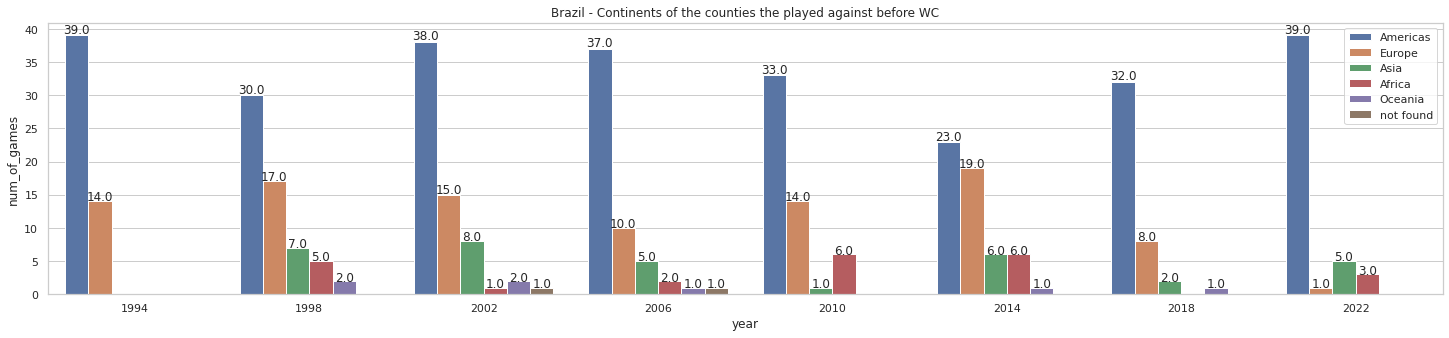

In [92]:
wc_history_list = []
df_continents = pd.DataFrame()
for i in range(14,len(df_wc_start_end_2022)): # Starting at the 1994 WC
    start_cycle_year = df_wc_start_end_2022['year'][i-1] # year that start the next wc cycle
    end_cycle_year = df_wc_start_end_2022['year'][i] # wc year, that ends the wc cycle

    df_wc_cycle = df_results[(df_results['teams_envolved'].apply(lambda x: x.__contains__(team))) &
                        (df_results['date'] > df_wc_start_end_2022[df_wc_start_end_2022['year'] == start_cycle_year]['date_end'].max()) & # greater than the end of last WC
                        (df_results['date'] < df_wc_start_end_2022[df_wc_start_end_2022['year'] == end_cycle_year]['date_start'].min())]  # smaller than the begging of current wc

    # Get the continents of the countries that the team played on that WC cycle
    # in the lambda function we get the name of the country that faced Brazil (team) and use the dict_country_continent to get the corresponding continent
    df_continents_year = df_wc_cycle['teams_envolved'].apply(lambda x: dict_country_continent[[t for t in x if t != team][0]]).value_counts().reset_index()
    # Adding a year column
    df_continents_year['year'] = end_cycle_year
    df_continents = pd.concat([df_continents, df_continents_year])

df_continents.rename(columns = {'index':'continents','teams_envolved':'num_of_games'}, inplace = True)

# ************************************* PLOT ***************************************
plt.figure(figsize=(25,5))
plt.title(f"{team} - Continents of the counties the played against before WC")
sns.set_theme(style="whitegrid")

p = sns.barplot(data = df_continents,
            x = 'year',
            y = 'num_of_games',
            hue = 'continents')
plt.legend(loc='upper right')
#show values on barplot
show_values(p)

From the graph we can see that indeed Brazil has been facing less europeans country. This time, due to the UEFA Nationals League they only played one game against an european country.